In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.cm
from scipy.stats import ttest_ind
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from datetime import datetime, timedelta
from dateutil.parser import parse
import math
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
import os

import matplotlib.pyplot as plt

 
%matplotlib inline

Read csv and create figure size for notebook

In [2]:
plt.rcParams["figure.figsize"] = (20,10)
ufo = pd.read_csv('/Users/richardlafferty/Downloads/scrubbed.csv')
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

/Users/richardlafferty/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Rename columns for easier input

In [3]:
ufo.rename(columns = {'duration (seconds)':'duration_seconds',
                      'duration (hours/min)': 'duration_hrs_min',
                      'date posted': 'date_posted'}, inplace = True)

Replacing incompatible timestamps

In [4]:
ufo['datetime'] = ufo['datetime'].apply(lambda x: x + ':00')

In [5]:
ufo.datetime.replace('24:00:00', '00:00:00')


0        10/10/1949 20:30:00
1        10/10/1949 21:00:00
2        10/10/1955 17:00:00
3        10/10/1956 21:00:00
4        10/10/1960 20:00:00
5        10/10/1961 19:00:00
6        10/10/1965 21:00:00
7        10/10/1965 23:45:00
8        10/10/1966 20:00:00
9        10/10/1966 21:00:00
10       10/10/1968 13:00:00
11       10/10/1968 19:00:00
12       10/10/1970 16:00:00
13       10/10/1970 19:00:00
14       10/10/1971 21:00:00
15       10/10/1972 19:00:00
16       10/10/1972 22:30:00
17       10/10/1973 19:00:00
18       10/10/1973 23:00:00
19       10/10/1974 19:30:00
20       10/10/1974 21:30:00
21       10/10/1974 23:00:00
22       10/10/1975 17:00:00
23       10/10/1976 20:30:00
24       10/10/1976 22:00:00
25       10/10/1977 12:00:00
26       10/10/1977 22:00:00
27       10/10/1978 02:00:00
28       10/10/1979 00:00:00
29       10/10/1979 22:00:00
                ...         
80302      9/9/2012 20:00:00
80303      9/9/2012 20:10:00
80304      9/9/2012 20:30:00
80305      9/9

Seperating date from time

In [6]:
ufo['date'] = ufo['datetime'].map(lambda x: str(x)[:-8])
ufo['date'] = ufo['date'].str.strip()
ufo['year'] = ufo['date'].map(lambda x: str(x)[-4:])
ufo['year'] = ufo['year'].str.split('/')
ufo['time'] = ufo['datetime'].map(lambda x: str(x)[-8:])


In [7]:
print(ufo['date'])
print(ufo['time'])

0        10/10/1949
1        10/10/1949
2        10/10/1955
3        10/10/1956
4        10/10/1960
5        10/10/1961
6        10/10/1965
7        10/10/1965
8        10/10/1966
9        10/10/1966
10       10/10/1968
11       10/10/1968
12       10/10/1970
13       10/10/1970
14       10/10/1971
15       10/10/1972
16       10/10/1972
17       10/10/1973
18       10/10/1973
19       10/10/1974
20       10/10/1974
21       10/10/1974
22       10/10/1975
23       10/10/1976
24       10/10/1976
25       10/10/1977
26       10/10/1977
27       10/10/1978
28       10/10/1979
29       10/10/1979
            ...    
80302      9/9/2012
80303      9/9/2012
80304      9/9/2012
80305      9/9/2012
80306      9/9/2012
80307      9/9/2012
80308      9/9/2012
80309      9/9/2012
80310      9/9/2012
80311      9/9/2012
80312      9/9/2012
80313      9/9/2013
80314      9/9/2013
80315      9/9/2013
80316      9/9/2013
80317      9/9/2013
80318      9/9/2013
80319      9/9/2013
80320      9/9/2013


Convert datetime by adding date and time seperately

In [8]:
ufo['datetime'] = pd.to_datetime(ufo.date) + pd.to_timedelta(ufo.time)

Change year column to be the year of datetime which is an integer

In [9]:
ufo['year'] = ufo['datetime'].dt.year

In [10]:
print(ufo.datetime.dtypes)

datetime64[ns]


In [22]:
print(ufo['year'].head())

0    1949
1    1949
2    1955
3    1956
4    1960
Name: year, dtype: int64


change latitude from an object to a float

In [12]:
ufo['latitude'] = pd.to_numeric(ufo['latitude'], errors = 'coerce')


Strip whitespace in longitude header

In [13]:
ufo.rename(columns = {'longitude ': 'longitude'}, inplace = True)

In [14]:
print(ufo['latitude'].mean())
print(ufo['longitude'].mean())
print(ufo['latitude'].median())
print(ufo['longitude'].median())


38.12447682461752
-86.77288454711757
39.41111110000001
-87.90361109999999


Changing the duration in seconds to a float

In [15]:
ufo['duration_seconds'] = pd.to_numeric(ufo.duration_seconds, errors = 'coerce')

In [16]:
for row_num, row in enumerate(ufo, start=1):
    try:
        pd.to_datetime(ufo.datetime, infer_datetime_format = True)
    except ValueError as err:
        print("Invalid data, row is skipped")
        print('Row: {}, Reason : {}'.format(row_num, err))
       
   

In [17]:
for row_num, row in enumerate(ufo, start=1):
    try:
        pd.to_numeric(ufo.duration_seconds)
    except ValueError as err:
        print("Invalid data, row is skipped")
        print('Row: {}, Reason : {}'.format(row_num, err))
    

In [18]:
print(ufo.dtypes)

datetime            datetime64[ns]
city                        object
state                       object
country                     object
shape                       object
duration_seconds           float64
duration_hrs_min            object
comments                    object
date_posted                 object
latitude                   float64
longitude                  float64
date                        object
year                         int64
time                        object
dtype: object


In [19]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world = world[world.name != 'Antarctica']

long_lat_points = [Point(xy) for xy in zip(ufo['longitude'], ufo['latitude'])]

crs = {"init": "epsg:4326"}


In [20]:
long_lat_points[:3]

Plot a histogram of number of ufos seen by year

AttributeError: 'tuple' object has no attribute 'set_xlim'

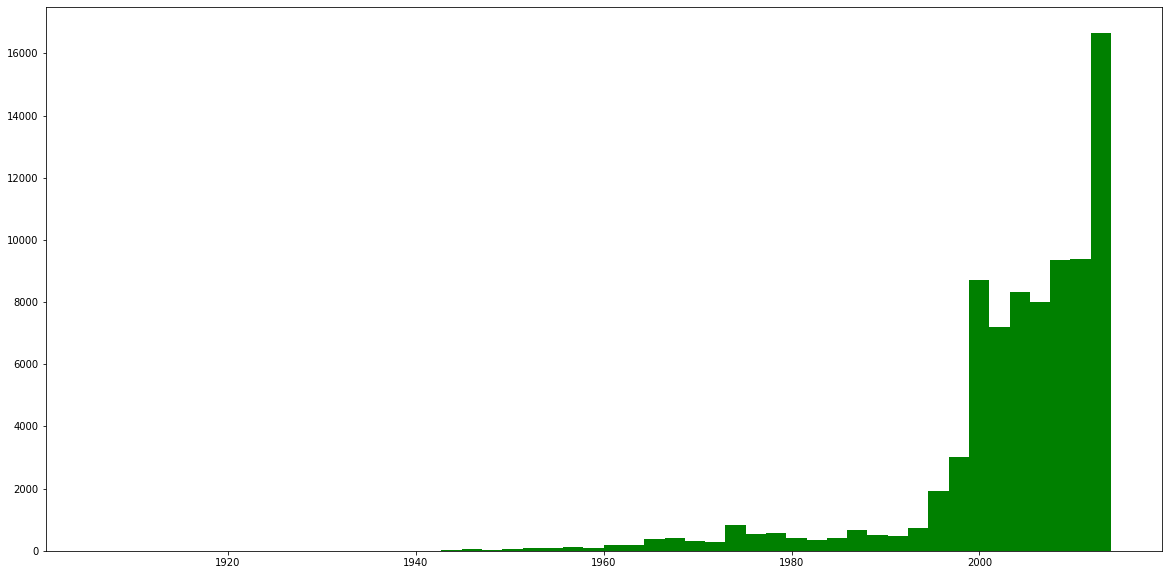

In [35]:
ax = plt.hist(ufo['year'], bins = 50, color = 'green')
ax.set_xlim(xmin = 1949, xmax = 2013)

Finding different shapes seen and their counts

In [24]:
shapes_seen = ufo.groupby('shape').shape.agg(['count'])

In [25]:
print(shapes_seen)

           count
shape           
changed        1
changing    1962
chevron      952
cigar       2057
circle      7608
cone         316
crescent       2
cross        233
cylinder    1283
delta          7
diamond     1178
disk        5213
dome           1
egg          759
fireball    6208
flare          1
flash       1328
formation   2457
hexagon        1
light      16565
other       5649
oval        3733
pyramid        1
rectangle   1297
round          2
sphere      5387
teardrop     750
triangle    7865
unknown     5584


In [26]:
light = ufo.loc[ufo['shape'] == 'light']
changing = ufo.loc[ufo['shape'] == 'changing']
chevron = ufo.loc[ufo['shape'] == 'chevron']
cigar = ufo.loc[ufo['shape'] == 'cigar']
circle = ufo.loc[ufo['shape'] == 'circle']
cone = ufo.loc[ufo['shape'] == 'cone']
crescent = ufo.loc[ufo['shape'] == 'crescent']
cross = ufo.loc[ufo['shape'] == 'cross']
cylinder = ufo.loc[ufo['shape'] == 'cylinder']






In [27]:
median_sighting = Point(38.1244768246185, -86.7728845471172)

In [28]:
print(ufo.head())

             datetime                  city state country     shape  \
0 1949-10-10 20:30:00            san marcos    tx      us  cylinder   
1 1949-10-10 21:00:00          lackland afb    tx     NaN     light   
2 1955-10-10 17:00:00  chester (uk/england)   NaN      gb    circle   
3 1956-10-10 21:00:00                  edna    tx      us    circle   
4 1960-10-10 20:00:00               kaneohe    hi      us     light   

   duration_seconds duration_hrs_min  \
0            2700.0       45 minutes   
1            7200.0          1-2 hrs   
2              20.0       20 seconds   
3              20.0         1/2 hour   
4             900.0       15 minutes   

                                            comments date_posted   latitude  \
0  This event took place in early fall around 194...   4/27/2004  29.883056   
1  1949 Lackland AFB&#44 TX.  Lights racing acros...  12/16/2005  29.384210   
2  Green/Orange circular disc over Chester&#44 En...   1/21/2008  53.200000   
3  My older brot

/Users/richardlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.


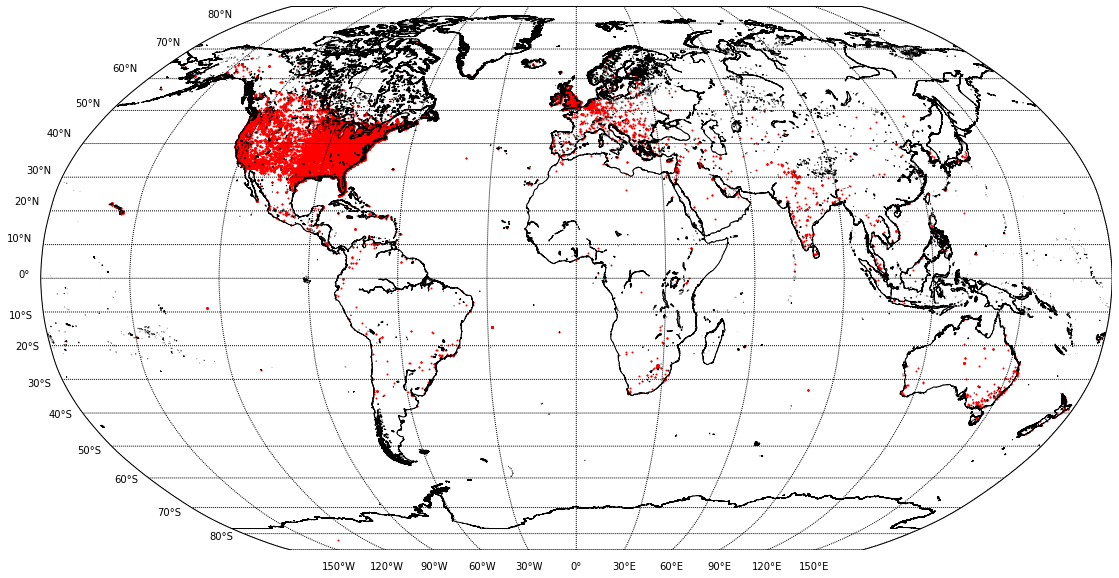

In [29]:
m = Basemap(projection='robin',lon_0=0,resolution='f')
m.drawcoastlines()
m.drawparallels(np.arange(-90, 90, 10), labels = [True, False, False, False])
m.drawmeridians(np.arange(-180, 180, 30), labels = [0, 0, 0, 1])

m.scatter(ufo.longitude.to_list(), ufo.latitude.to_list(), latlon = True, s = 1, c = 'red')
plt.show()

/Users/richardlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


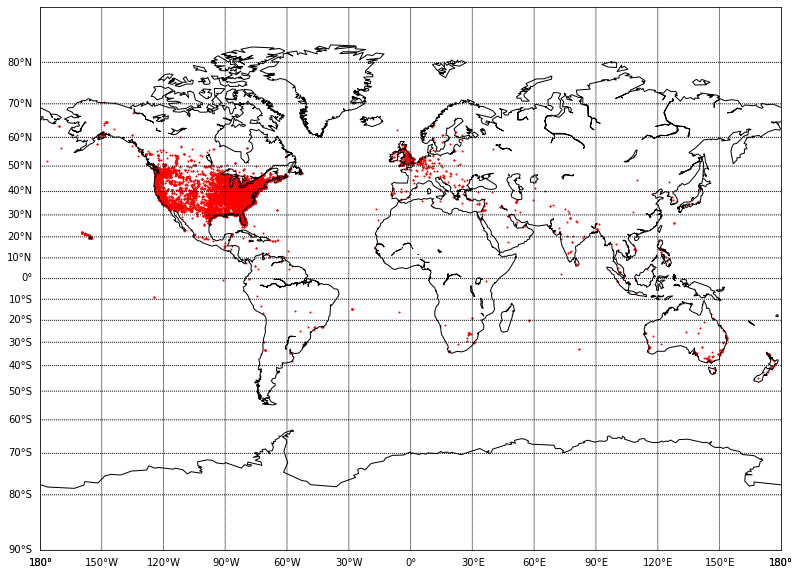

In [30]:
m = Basemap(projection = 'mill',
           llcrnrlat = -90,
           urcrnrlat = 90,
           llcrnrlon = -180,
           urcrnrlon = 180,
           resolution = 'c')
m.drawcoastlines()
m.drawparallels(np.arange(-90, 90, 10), labels = [True, False, False, False])
m.drawmeridians(np.arange(-180, 180, 30), labels = [0, 0, 0, 1])

m.scatter(light.longitude.to_list(), light.latitude.to_list(), latlon = True, s = 1, c = 'red')

/Users/richardlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  import sys


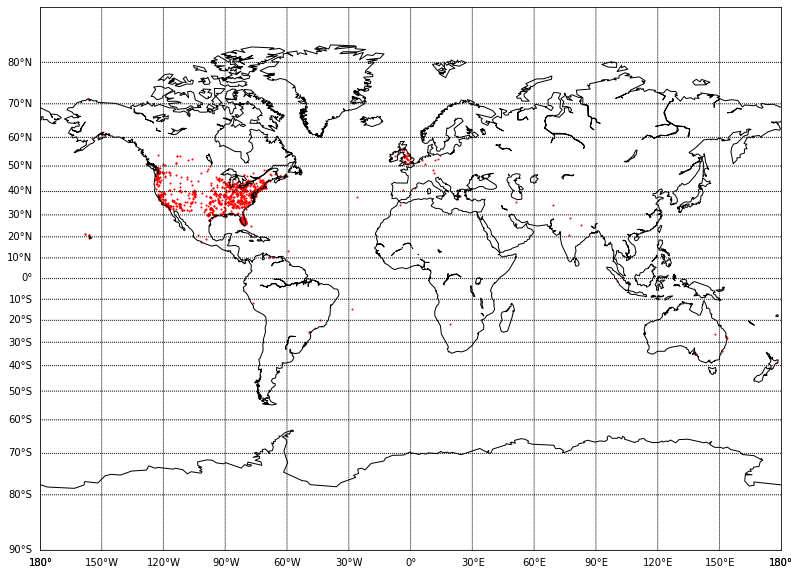

In [31]:
cylinder = ufo.loc[ufo['shape'] == 'cylinder']
m = Basemap(projection = 'mill',
           llcrnrlat = -90,
           urcrnrlat = 90,
           llcrnrlon = -180,
           urcrnrlon = 180,
           resolution = 'c')
m.drawcoastlines()
m.drawparallels(np.arange(-90, 90, 10), labels = [True, False, False, False])
m.drawmeridians(np.arange(-180, 180, 30), labels = [0, 0, 0, 1])
m.scatter(cylinder.longitude.to_list(), cylinder.latitude.to_list(), latlon = True, s = 1, c = 'red')


In [ ]:
m = Basemap(projection = 'mill',
           llcrnrlat = 22,
           urcrnrlat = 55,
           llcrnrlon = -128,
           urcrnrlon = -60,
           resolution = 'c')
m.drawcoastlines()
m.readshapefile('/Users/richardlafferty/Downloads/tl_2017_us_state/tl_2017_us_state', 'areas')
m.scatter(ufo.longitude.to_list(), ufo.latitude.to_list(), latlon = True, s = 2, c = 'red')


/Users/richardlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
/Users/richardlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


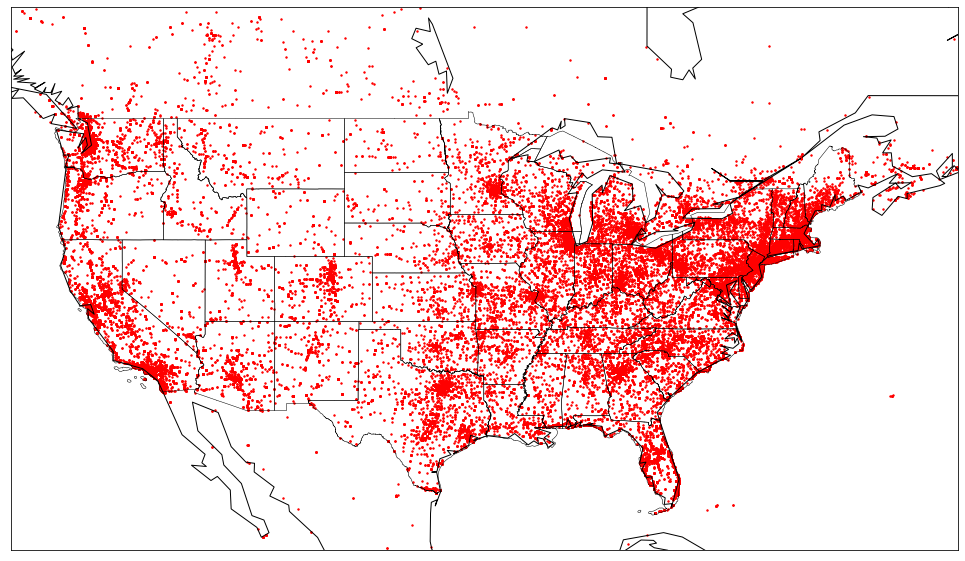

In [33]:
m = Basemap(projection = 'mill',
           llcrnrlat = 22,
           urcrnrlat = 55,
           llcrnrlon = -128,
           urcrnrlon = -60,
           resolution = 'c')
m.drawcoastlines()
m.readshapefile('/Users/richardlafferty/Downloads/tl_2017_us_state/tl_2017_us_state', 'areas')
m.scatter(ufo.longitude.to_list(), ufo.latitude.to_list(), latlon = True, s = 2, c = 'red')